In [1]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [8]:
%%writefile zkp_comparison.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>  // For gettimeofday
#include <pthread.h>   // Using pthreads instead of OpenMP

#define THREADS_PER_BLOCK 256
#define MAX_CPU_THREADS 16  // Maximum number of CPU threads to use

// Structure for thread arguments
typedef struct {
    unsigned long long g;
    unsigned long long h;
    unsigned long long p;
    unsigned long long *commitments;
    unsigned long long *responses;
    unsigned long long *challenges;
    int *results;
    int start_idx;
    int end_idx;
} ThreadArgs;

// Host version of modPow for initialization
unsigned long long hostModPow(unsigned long long base, unsigned long long exponent,
                         unsigned long long modulus) {
    unsigned long long result = 1;
    base = base % modulus;

    while (exponent > 0) {
        if (exponent % 2 == 1) {
            result = (result * base) % modulus;
        }
        exponent = exponent >> 1;
        base = (base * base) % modulus;
    }
    return result;
}

// Device version of modPow
__device__ unsigned long long deviceModPow(unsigned long long base, unsigned long long exponent,
                                     unsigned long long modulus) {
    unsigned long long result = 1;
    base = base % modulus;

    while (exponent > 0) {
        if (exponent % 2 == 1) {
            result = (result * base) % modulus;
        }
        exponent = exponent >> 1;
        base = (base * base) % modulus;
    }
    return result;
}

// GPU Kernel for verification
__global__ void gpuVerifyProofs(unsigned long long g, unsigned long long h, unsigned long long p,
                              unsigned long long *commitments, unsigned long long *responses,
                              unsigned long long *challenges, int *results, int numChallenges) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < numChallenges) {
        unsigned long long left = deviceModPow(g, responses[idx], p);
        unsigned long long right = (commitments[idx] * deviceModPow(h, challenges[idx], p)) % p;
        results[idx] = (left == right) ? 1 : 0;
    }
}

// Function for each CPU thread
void* threadVerifyProofs(void* arg) {
    ThreadArgs* args = (ThreadArgs*)arg;

    for (int i = args->start_idx; i < args->end_idx; i++) {
        unsigned long long left = hostModPow(args->g, args->responses[i], args->p);
        unsigned long long right = (args->commitments[i] * hostModPow(args->h, args->challenges[i], args->p)) % args->p;
        args->results[i] = (left == right) ? 1 : 0;
    }

    return NULL;
}

// Multithreaded CPU-based verifier using pthreads
void cpuVerifyProofs(unsigned long long g, unsigned long long h, unsigned long long p,
                   unsigned long long *commitments, unsigned long long *responses,
                   unsigned long long *challenges, int *results, int numChallenges,
                   int numThreads) {

    // Cap the number of threads to MAX_CPU_THREADS and the number of challenges
    if (numThreads > MAX_CPU_THREADS)
        numThreads = MAX_CPU_THREADS;
    if (numThreads > numChallenges)
        numThreads = numChallenges;

    // Create thread handles and arguments
    pthread_t threads[MAX_CPU_THREADS];
    ThreadArgs threadArgs[MAX_CPU_THREADS];

    // Calculate challenges per thread
    int challengesPerThread = numChallenges / numThreads;
    int remainingChallenges = numChallenges % numThreads;

    // Start threads
    int startIdx = 0;
    for (int i = 0; i < numThreads; i++) {
        threadArgs[i].g = g;
        threadArgs[i].h = h;
        threadArgs[i].p = p;
        threadArgs[i].commitments = commitments;
        threadArgs[i].responses = responses;
        threadArgs[i].challenges = challenges;
        threadArgs[i].results = results;
        threadArgs[i].start_idx = startIdx;

        int extra = (i < remainingChallenges) ? 1 : 0;
        int threadChallenges = challengesPerThread + extra;

        threadArgs[i].end_idx = startIdx + threadChallenges;
        startIdx += threadChallenges;

        pthread_create(&threads[i], NULL, threadVerifyProofs, &threadArgs[i]);
    }

    // Join threads
    for (int i = 0; i < numThreads; i++) {
        pthread_join(threads[i], NULL);
    }
}

// Helper function to get time in milliseconds
double getTimeMs() {
    struct timeval tv;
    gettimeofday(&tv, NULL);
    return (tv.tv_sec * 1000.0 + tv.tv_usec / 1000.0);
}

int main() {
    // Open a file to save results
    FILE *results_file = fopen("zkp_results.txt", "w");
    if (results_file == NULL) {
        printf("Error opening results file!\n");
        return 1;
    }

    // Set number of CPU threads to use
    int num_cpu_threads = 8;  // Adjust based on your system

    printf("Running CPU vs GPU Comparison Test for ZKP Verifier...\n");
    printf("Using %d CPU threads for parallel verification\n", num_cpu_threads);
    fprintf(results_file, "batch_size,cpu_threads,cpu_time_ms,gpu_time_ms,cpu_throughput,gpu_throughput,speedup\n");

    // Parameters
    unsigned long long g = 2;
    unsigned long long witness = 42;
    unsigned long long p = 2147483647;  // 2^31 - 1
    unsigned long long h = hostModPow(g, witness, p);

    printf("Protocol parameters:\n");
    printf("  Generator (g): %llu\n", g);
    printf("  Public key (h = g^witness mod p): %llu\n", h);
    printf("  Modulus (p): %llu\n\n", p);

    // Different batch sizes to test
    int batchSizes[] = {1000, 10000, 100000, 1000000};

    for (int b = 0; b < sizeof(batchSizes)/sizeof(batchSizes[0]); b++) {
        int numChallenges = batchSizes[b];
        printf("Testing batch size: %d\n", numChallenges);

        // Allocate memory for CPU test
        unsigned long long *challenges = (unsigned long long*)malloc(numChallenges * sizeof(unsigned long long));
        unsigned long long *commitments = (unsigned long long*)malloc(numChallenges * sizeof(unsigned long long));
        unsigned long long *responses = (unsigned long long*)malloc(numChallenges * sizeof(unsigned long long));
        int *cpuResults = (int*)malloc(numChallenges * sizeof(int));

        // Generate test data
        for (int i = 0; i < numChallenges; i++) {
            challenges[i] = i % 1000;
            unsigned long long r = i % 1000000;  // Deterministic for reproducibility
            commitments[i] = hostModPow(g, r, p);
            responses[i] = (r + challenges[i] * witness) % (p-1);
        }

        // Timing the multithreaded CPU implementation
        double cpuStartTime = getTimeMs();
        cpuVerifyProofs(g, h, p, commitments, responses, challenges, cpuResults, numChallenges, num_cpu_threads);
        double cpuEndTime = getTimeMs();

        // Check CPU results
        int cpuPassedVerifications = 0;
        for (int i = 0; i < numChallenges; i++) {
            cpuPassedVerifications += cpuResults[i];
        }

        double cpuTime = cpuEndTime - cpuStartTime;  // Already in ms
        double cpuThroughput = numChallenges / (cpuTime / 1000.0);  // proofs/second

        printf("  Multithreaded CPU verification (%d threads): %d/%d proofs verified in %.2f ms (%.2f proofs/second)\n",
               num_cpu_threads, cpuPassedVerifications, numChallenges, cpuTime, cpuThroughput);

        // Now set up GPU verification
        unsigned long long *d_challenges, *d_commitments, *d_responses;
        int *d_results, *h_gpuResults;

        // Allocate device memory
        cudaMalloc(&d_challenges, numChallenges * sizeof(unsigned long long));
        cudaMalloc(&d_commitments, numChallenges * sizeof(unsigned long long));
        cudaMalloc(&d_responses, numChallenges * sizeof(unsigned long long));
        cudaMalloc(&d_results, numChallenges * sizeof(int));

        h_gpuResults = (int*)malloc(numChallenges * sizeof(int));

        // Copy data to device
        cudaMemcpy(d_challenges, challenges, numChallenges * sizeof(unsigned long long), cudaMemcpyHostToDevice);
        cudaMemcpy(d_commitments, commitments, numChallenges * sizeof(unsigned long long), cudaMemcpyHostToDevice);
        cudaMemcpy(d_responses, responses, numChallenges * sizeof(unsigned long long), cudaMemcpyHostToDevice);

        // CUDA timing events
        cudaEvent_t gpuStart, gpuStop;
        cudaEventCreate(&gpuStart);
        cudaEventCreate(&gpuStop);

        // Calculate grid dimensions
        int numBlocks = (numChallenges + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;

        // Timing the GPU implementation
        cudaEventRecord(gpuStart);
        gpuVerifyProofs<<<numBlocks, THREADS_PER_BLOCK>>>(g, h, p, d_commitments, d_responses, d_challenges, d_results, numChallenges);
        cudaEventRecord(gpuStop);
        cudaEventSynchronize(gpuStop);

        // Copy results back
        cudaMemcpy(h_gpuResults, d_results, numChallenges * sizeof(int), cudaMemcpyDeviceToHost);

        // Check GPU results
        int gpuPassedVerifications = 0;
        for (int i = 0; i < numChallenges; i++) {
            gpuPassedVerifications += h_gpuResults[i];
        }

        float gpuTime = 0;
        cudaEventElapsedTime(&gpuTime, gpuStart, gpuStop);
        double gpuThroughput = numChallenges / (gpuTime / 1000.0);  // proofs/second

        printf("  GPU verification: %d/%d proofs verified in %.2f ms (%.2f proofs/second)\n",
               gpuPassedVerifications, numChallenges, gpuTime, gpuThroughput);

        // Calculate speedup
        float speedup = cpuTime / gpuTime;
        printf("  Speedup: %.2fx\n\n", speedup);

        // Save results to file in CSV format
        fprintf(results_file, "%d,%d,%.2f,%.2f,%.2f,%.2f,%.2f\n",
                numChallenges, num_cpu_threads, cpuTime, gpuTime, cpuThroughput, gpuThroughput, speedup);

        // Clean up
        free(challenges);
        free(commitments);
        free(responses);
        free(cpuResults);
        free(h_gpuResults);
        cudaFree(d_challenges);
        cudaFree(d_commitments);
        cudaFree(d_responses);
        cudaFree(d_results);
        cudaEventDestroy(gpuStart);
        cudaEventDestroy(gpuStop);
    }

    fclose(results_file);
    printf("Results saved to zkp_results.txt\n");

    return 0;
}

Overwriting zkp_comparison.cu


In [9]:
!nvcc -arch=sm_80 zkp_comparison.cu -o zkp_comparison -lpthread

# Execute the program
!./zkp_comparison

Running CPU vs GPU Comparison Test for ZKP Verifier...
Using 8 CPU threads for parallel verification
Protocol parameters:
  Generator (g): 2
  Public key (h = g^witness mod p): 2048
  Modulus (p): 2147483647

Testing batch size: 1000
  Multithreaded CPU verification (8 threads): 1000/1000 proofs verified in 0.36 ms (2801641.59 proofs/second)
  GPU verification: 1000/1000 proofs verified in 0.13 ms (7875504.14 proofs/second)
  Speedup: 2.81x

Testing batch size: 10000
  Multithreaded CPU verification (8 threads): 10000/10000 proofs verified in 1.13 ms (8835202.76 proofs/second)
  GPU verification: 10000/10000 proofs verified in 0.03 ms (349944013.09 proofs/second)
  Speedup: 39.61x

Testing batch size: 100000
  Multithreaded CPU verification (8 threads): 100000/100000 proofs verified in 8.34 ms (11986070.87 proofs/second)
  GPU verification: 100000/100000 proofs verified in 0.06 ms (1798043767.07 proofs/second)
  Speedup: 150.01x

Testing batch size: 1000000
  Multithreaded CPU verifica

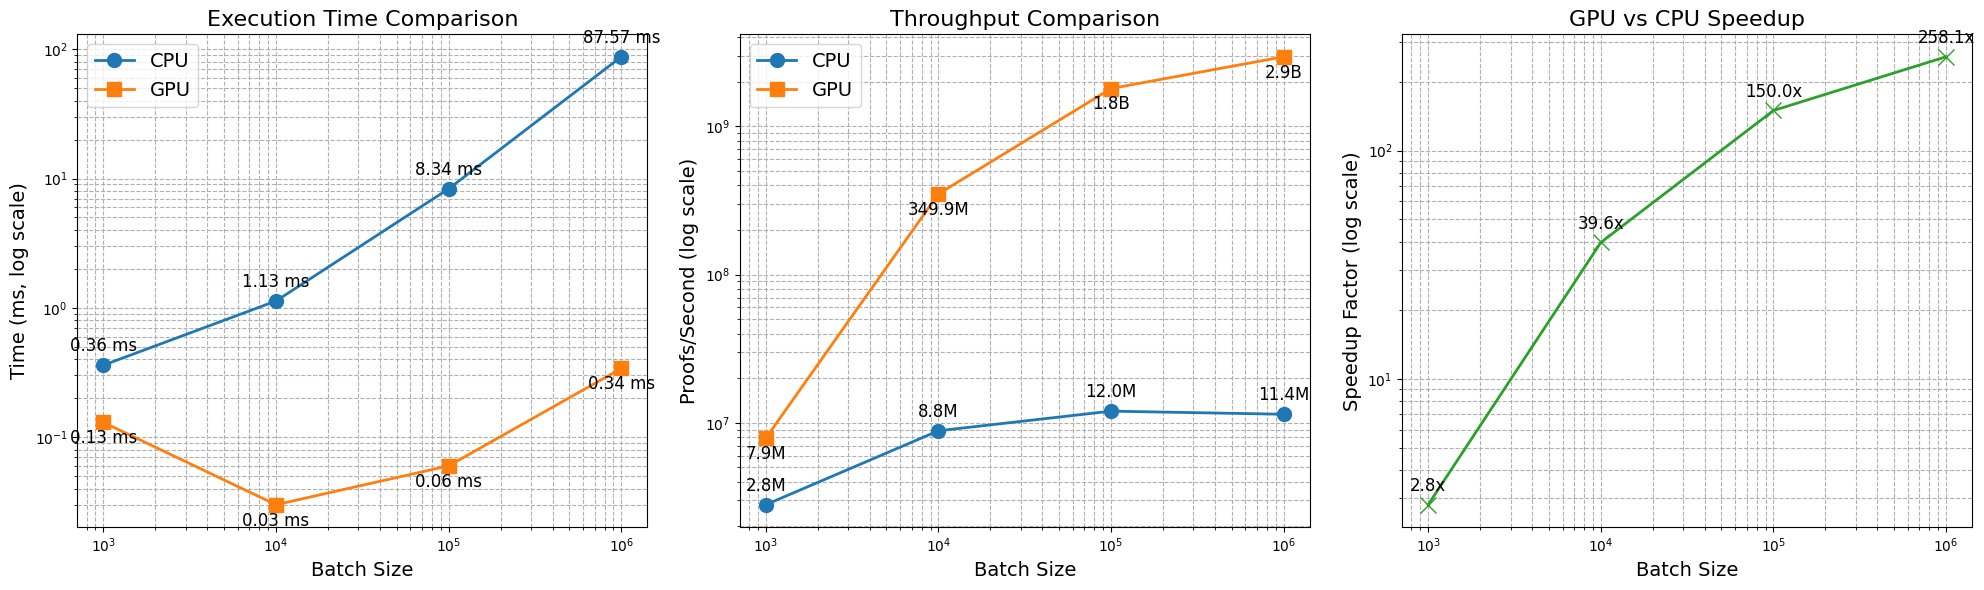

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Read the results from the file
results = pd.read_csv('zkp_results.txt')

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Execution time comparison
ax1.set_title('Execution Time Comparison', fontsize=16)
ax1.set_xlabel('Batch Size', fontsize=14)
ax1.set_ylabel('Time (ms, log scale)', fontsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(results['batch_size'], results['cpu_time_ms'], 'o-', label='CPU', linewidth=2, markersize=10, color='#1f77b4')
ax1.plot(results['batch_size'], results['gpu_time_ms'], 's-', label='GPU', linewidth=2, markersize=10, color='#ff7f0e')
ax1.grid(True, which="both", ls="--")
ax1.legend(fontsize=14)

# Add value annotations
for i, row in results.iterrows():
    ax1.annotate(f"{row['cpu_time_ms']:.2f} ms", (row['batch_size'], row['cpu_time_ms']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
    ax1.annotate(f"{row['gpu_time_ms']:.2f} ms", (row['batch_size'], row['gpu_time_ms']),
                 textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)

# Plot 2: Throughput comparison
ax2.set_title('Throughput Comparison', fontsize=16)
ax2.set_xlabel('Batch Size', fontsize=14)
ax2.set_ylabel('Proofs/Second (log scale)', fontsize=14)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(results['batch_size'], results['cpu_throughput'], 'o-', label='CPU', linewidth=2, markersize=10, color='#1f77b4')
ax2.plot(results['batch_size'], results['gpu_throughput'], 's-', label='GPU', linewidth=2, markersize=10, color='#ff7f0e')
ax2.grid(True, which="both", ls="--")
ax2.legend(fontsize=14)

# Format throughput values for readability
def format_throughput(value):
    if value < 1e6:
        return f"{value/1e3:.1f}K"
    elif value < 1e9:
        return f"{value/1e6:.1f}M"
    else:
        return f"{value/1e9:.1f}B"

# Add throughput annotations
for i, row in results.iterrows():
    cpu_formatted = format_throughput(row['cpu_throughput'])
    gpu_formatted = format_throughput(row['gpu_throughput'])

    ax2.annotate(cpu_formatted, (row['batch_size'], row['cpu_throughput']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
    ax2.annotate(gpu_formatted, (row['batch_size'], row['gpu_throughput']),
                 textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)

# Plot 3: Speedup
ax3.set_title('GPU vs CPU Speedup', fontsize=16)
ax3.set_xlabel('Batch Size', fontsize=14)
ax3.set_ylabel('Speedup Factor (log scale)', fontsize=14)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.plot(results['batch_size'], results['speedup'], 'x-', linewidth=2, markersize=12, color='#2ca02c')
ax3.grid(True, which="both", ls="--")

# Add speedup annotations
for i, row in results.iterrows():
    ax3.annotate(f"{row['speedup']:.1f}x", (row['batch_size'], row['speedup']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

plt.tight_layout()
plt.show()